In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossBinary, DiceLoss

from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [4]:
class FocalLossMultiClass(FocalLossBinary):
    """
    Compute focal loss for multi-class problem.
    Ignores targets having -1 label
    """
    eps=1e-10
    def to_onehot(self, indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
                             dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.unsqueeze(1), 1)

    def forward(self, logits, targets):
        """
        Args:
            logits: [bs; num_classes; ...]
            targets: [bs; ...]
        """
        num_classes = logits.size(1)
        loss = 0
        # one hot encode 
#         targets = self.to_onehot(targets.view(-1), num_classes=num_classes)
        logits = logits.view(-1, num_classes)
        
        print(targets.shape, logits.shape)
        

        # Filter anchors with -1 label from loss computation
        if self.ignore is not None:
            not_ignored = targets != self.ignore

        for cls in range(num_classes):
            cls_label_target = (targets == (cls + 0)).long()
            cls_label_input = logits[..., cls]

            if self.ignore is not None:
                cls_label_target = cls_label_target[not_ignored]
                cls_label_input = cls_label_input[not_ignored]

            loss += self.loss_fn(cls_label_input, cls_label_target)

        return loss

In [5]:
fc_loss =  FocalLossMultiClass()
d_loss = DiceLoss()

def focal_dice_loss(logits, targets):
    focal_loss = fc_loss(logits, targets)
    dice_loss = d_loss(logits, targets)
    
    return 0.8 * focal_loss + 0.2 * dice_loss

In [6]:
data_dir = Path("/media/wwymak/Storage/xView2")
models_path = data_dir / "models"
classifcation_crop_dir = data_dir/"classification_crops"
classification_labels = pd.read_csv(data_dir/"train.csv")

In [7]:
def get_train_valid_ids(classification_labels_df, valid_pct=0.1, random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df.img_id.unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df.img_id.isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df.img_id.isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids
    

In [8]:
classification_labels_mini = classification_labels.sample(n=10000)
train_ids, valid_ids = get_train_valid_ids(classification_labels)
train_ids_mini, valid_ids_mini = get_train_valid_ids(classification_labels_mini)

In [40]:

def is_valid_func(img_fname):
    id = Path(img_fname).name
    return id in valid_ids


In [66]:

def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def to_onehot(indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.unsqueeze(1), 1)
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#


In [91]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class myCCELoss(nn.Module):

    def __init__(self):
        super(myCCELoss, self).__init__()

    def forward(self, input, target):
        y = one_hot_embedding(target, input.size(-1))
        logit = F.softmax(input)
       
        loss = -1 * V(y) * torch.log(logit) # cross entropy loss
        return loss.sum(dim=1).mean()
    
class FocalLoss(nn.Module):

    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        
    def to_onehot(self, indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.unsqueeze(1), 1)

    def forward(self, input, target, **kwargs):
        y = self.to_onehot(target, input.size(-1))
        logit = F.softmax(input)
        logit = logit.clamp(self.eps, 1. - self.eps)
        loss = F.binary_cross_entropy(logit.float(), y.float())
#         loss = -1 * V(y) * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss
        return loss.sum(dim=1).mean()


In [62]:
size=64
bs=32
src = (ImageList
       .from_df(classification_labels_mini, path=classifcation_crop_dir, cols=['crop_filename'])
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))

data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

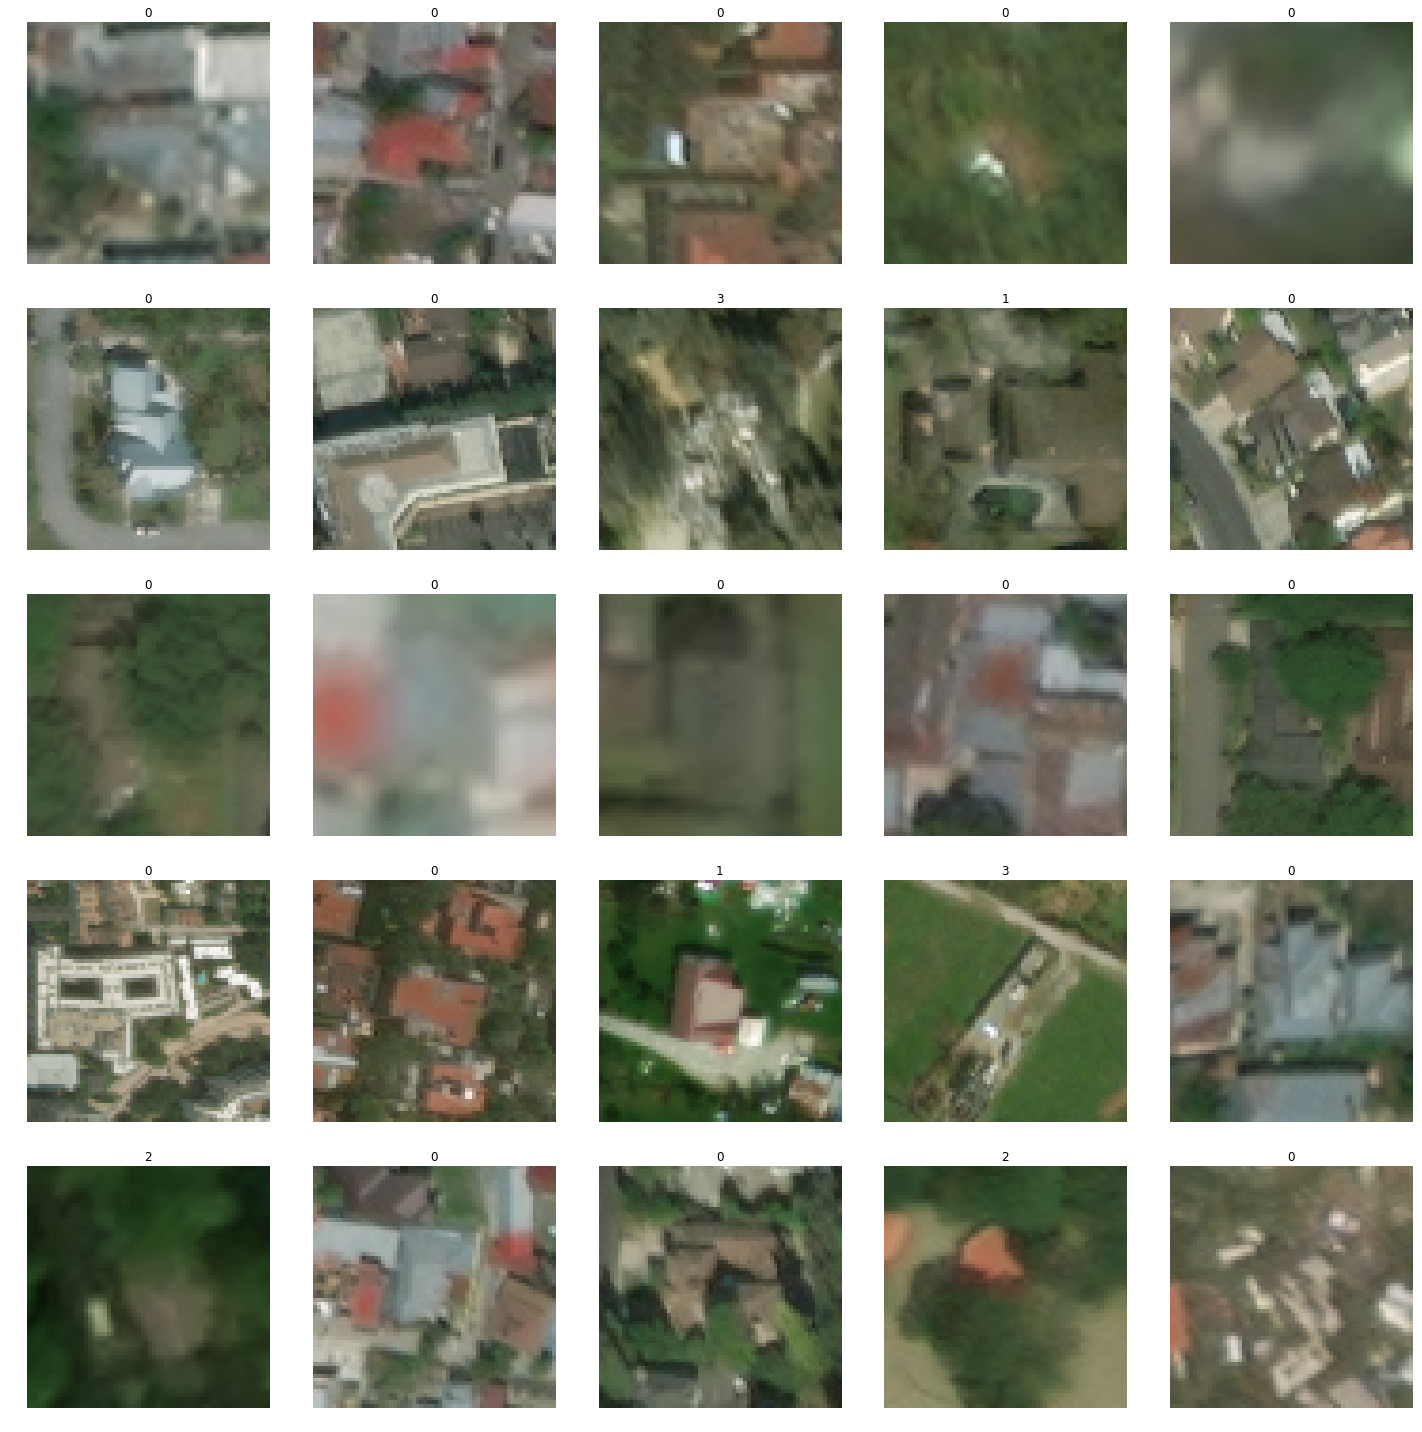

In [17]:
data.show_batch(ds_type=DatasetType.Valid)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


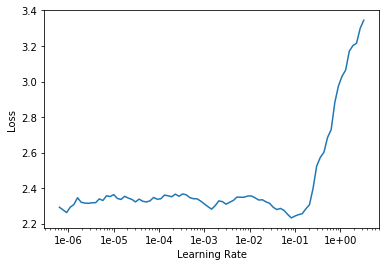

In [67]:

learn = cnn_learner(data,models.resnet50, metrics=[accuracy, f1])
learn.loss_func =FocalLoss(gamma=2.0)
learn.lr_find()
learn.recorder.plot()



In [68]:
learn.fit_one_cycle(1, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.216350,0.906867,0.713858,0.651362,00:15


In [69]:
learn.fit_one_cycle(3, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.037559,0.860966,0.759721,0.698016,00:13
1,0.828825,0.717070,0.793619,0.726127,00:13
2,0.788498,0.692645,0.804586,0.726648,00:13


In [71]:
learn.model_dir = models_path
learn.save('24Nov-classification_focal_loss')

In [72]:
src = (ImageList
       .from_df(classification_labels, path=classifcation_crop_dir, cols=['crop_filename'])
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn.data = data
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (146535 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /media/wwymak/Storage/xView2/classification_crops;

Valid: LabelList (16252 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
2,2,1,1,1
Path: /media/wwymak/Storage/xView2/classification_crops;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

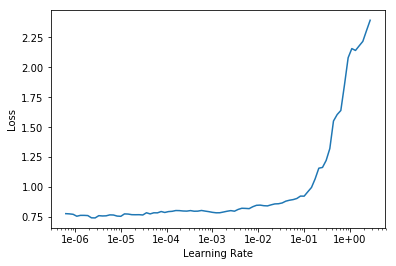

In [74]:
# learn.lr_find()
learn.recorder.plot()

In [75]:
learn.fit_one_cycle(3, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.781087,0.687558,0.798732,0.726172,23:31
1,0.770116,0.676395,0.802609,0.726802,04:40
2,0.746209,0.677580,0.799594,0.730087,04:40


In [76]:
learn.save('24Nov-classification_focal_loss')

In [78]:
lr=1e-5
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1', name='24Nov-classification_focal_loss'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

learn.fit_one_cycle(5, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.735415,0.675258,0.803224,0.734122,04:36
1,0.744498,0.670761,0.803040,0.725170,04:42
2,0.725463,0.667782,0.803840,0.726790,04:46
3,0.747317,0.668613,0.804886,0.716827,04:42
4,0.750916,0.660736,0.805193,0.724760,04:41


Better model found at epoch 0 with f1 value: 0.7341215014457703.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


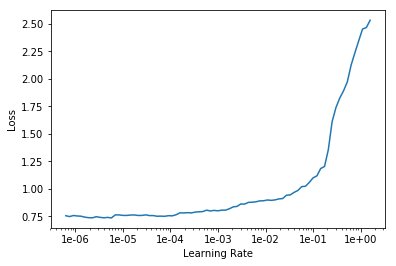

In [79]:
learn.load('24Nov-classification_focal_loss')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=2)

In [80]:
lr=1e-6
callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1', name='24Nov-classification_focal_loss_unfrozen'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

learn.fit_one_cycle(10, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.740880,0.673344,0.802732,0.728005,06:06
1,0.764685,0.670692,0.804393,0.725208,06:12
2,0.759543,0.669520,0.804086,0.732665,06:09
3,0.764750,0.669050,0.804455,0.733770,06:11
4,0.730166,0.666278,0.805255,0.729832,06:10
5,0.743143,0.660596,0.805501,0.733430,06:14
6,0.768647,0.663998,0.806731,0.733310,06:15
7,0.747566,0.661158,0.806485,0.728174,06:13
8,0.751979,0.661239,0.806178,0.737654,06:13
9,0.743050,0.663549,0.806731,0.732254,06:16


Better model found at epoch 0 with f1 value: 0.7280049920082092.
Better model found at epoch 2 with f1 value: 0.7326650619506836.
Better model found at epoch 3 with f1 value: 0.7337697744369507.
Better model found at epoch 8 with f1 value: 0.7376537322998047.


In [92]:
learn.loss_func =FocalLoss(gamma=2.0)
learn.load('24Nov-classification_focal_loss_unfrozen');

In [93]:
damage_crops_test_folder = data_dir / "classification_crops_test"
data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn.data = data

learn.to_fp16();

In [94]:
predictions, y, losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
y = torch.argmax(predictions, dim=1)

In [109]:
from cv2 import fillPoly, imwrite
def create_image(img_id, output_path):
    
    mask_img = np.zeros((1024,1024,1), np.uint8)
    img_polys = test_results[test_results.img_id == img_id]
    if len(img_polys) > 0:
        for r in img_polys.iterrows():
            row = r[1]
            poly_np = np.array(row.geometry.coords, np.int32)
            fillPoly(mask_img, [poly_np], row['damage_cls'])
            
    img_id.replace('post', 'damage').replace('pre', 'localization').replace('.png', '_prediction.png')

    imwrite(str(output_path/img_id), mask_img)
    return mask_img

In [98]:
labels = pd.read_csv(data_dir/"test_polygons.csv")
labels["crop_filename"] = labels.polygon_id.apply(lambda x: f"{x}.png")

polygon_ids = [x.name.replace('.png', '') for x in data.test_dl.dataset.items]
prediction_cls = [x+1 for x in y.numpy()]

test_results = pd.DataFrame(data={'polygon_id': polygon_ids, 'damage_cls': prediction_cls})
test_results = labels.merge(test_results, left_on='polygon_id', right_on='polygon_id')
test_results.geometry = test_results.geometry.apply(lambda x: wkt.loads(x).exterior)
test_results.img_id = test_results.img_id.str.replace('pre', 'post')

output_path = data_dir/"test_masks"
img_ids = [x.name for x in (data_dir/"test"/"images").ls() if 'post' in x.name]



outputs = [create_image(img_id, output_path) for img_id in tqdm(img_ids)]

100%|██████████| 933/933 [00:07<00:00, 128.38it/s]


In [9]:
def rename_to_submit(img_path):
    img_path.rename(Path(img_path.parent, img_path.name.replace('post', 'damage').replace('pre', 'localization').replace('.png', '_prediction.png')))

In [11]:
output_path = data_dir/"test_masks"
output_path.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/test_masks/test_damage_00777_localizationdiction_prediction.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_damage_00214_localizationdiction_prediction.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_damage_00483_localizationdiction_prediction.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_damage_00732_prediction.png'),
 PosixPath('/media/wwymak/Storage/xView2/test_masks/test_damage_00911_localizationdiction_prediction.png')]

In [101]:
_=[rename_to_submit(x) for x in output_path.ls()]

In [106]:
def load_and_validate_image( path):
    assert path.is_file(), f"file '{path}' does not exist or is not a file"
    img = np.array(PIL.Image.open(path))
    assert img.dtype == np.uint8, f"{path.name} is of wrong format {img.dtype} - should be np.uint8"
    assert set(np.unique(img)) <= {0,1,2,3,4}, f"values must ints 0-4, found {np.unique(img)}, path: {path}"
    assert img.shape == (1024,1024), f"{path} must be a 1024x1024 image"
    return img

In [107]:
_=[load_and_validate_image(x) for x in output_path.ls()]